# Text Classification with Transformers (ALBERT)

This script helps you fine-tune a pre-trained model (ALBERT) and encoder model for text classification with a dataset from the HuggingFace.

The use case uses binary classes to produce a model to identify clickbait versus factual content with the use of a synthetic dataset found [here](https://huggingface.co/datasets/ilsilfverskiold/clickbait_titles_synthetic_data). This script follows a tutorial that you can find here.

You may use any encoder model such as BERT, RoBERTa and DeBERTa instead.

In [1]:
!pip install -U datasets
!pip install -U accelerate
!pip install -U transformers
!pip install -U huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import os

split_exists = os.path.exists('./train.csv') and os.path.exists('./test.csv')

if split_exists:
    ds_train = Dataset.from_pandas(pd.read_csv("./train.csv"))
    ds_test = Dataset.from_pandas(pd.read_csv("./test.csv"))

    dataset = DatasetDict({"train": ds_train, "test": ds_test})
else:
    good = pd.read_csv('./good.csv')
    bad = pd.read_csv('./bad.csv')

    ds = pd.concat([good, bad], axis=0)

    train, test = train_test_split(ds, test_size=0.2)

    # Save the distribution
    train.to_csv('train.csv', sep=',', index=False, header=True, encoding='utf-8')
    test.to_csv('test.csv', sep=',', index=False, header=True, encoding='utf-8')

    dataset = Dataset.from_pandas(ds)

    dataset = dataset.train_test_split(test_size=0.2)

dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 32000
    })
    test: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 8000
    })
})

Import the dataset you'll be trainin on. This dataset has a 'text' field and a 'label' field. Be sure to tweak the script if you need to.

In [3]:
# from datasets import load_dataset, DatasetDict

# dataset = load_dataset("ilsilfverskiold/clickbait_titles_synthetic_data")
# dataset

Decide on your pre-trained model along with your new model's name.

In [4]:
model_name = "albert/albert-base-v2"
your_path = 'nomi'

Look over your distribution of the labels (optional)

In [5]:
from collections import Counter

train_label_distribution = Counter(dataset['train']['label'])
test_label_distribution = Counter(dataset['test']['label'])

print("Training Label Distribution:", train_label_distribution)
print("Test Label Distribution:", test_label_distribution)

Training Label Distribution: Counter({'good': 16035, 'bad': 15965})
Test Label Distribution: Counter({'bad': 4035, 'good': 3965})


Create a label encoder that converts categorical labels to a standardized numerical format. Labels in their original categorical form (e.g., 'clickbait', 'factual') need to be converted into numerical values so that they can be processed by the algorithms.

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(dataset['train']['label'])

def encode_labels(example):
    return {'encoded_label': label_encoder.transform([example['label']])[0]}

for split in dataset:
    dataset[split] = dataset[split].map(encode_labels, batched=False)

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

The id2label and label2id mappings in AutoConfig are used to inform the model of the specific label-to-ID mappings so we can get the actual label names rather than the numerical reps when we do inference with the model.

In [7]:
from transformers import AutoConfig

unique_labels = sorted(list(set(dataset['train']['label'])))
id2label = {i: label for i, label in enumerate(unique_labels)}
label2id = {label: i for i, label in enumerate(unique_labels)}

config = AutoConfig.from_pretrained(model_name)
config.id2label = id2label
config.label2id = label2id

# Verify the correct labels
print("ID to Label Mapping:", config.id2label)
print("Label to ID Mapping:", config.label2id)

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

ID to Label Mapping: {0: 'bad', 1: 'good'}
Label to ID Mapping: {'bad': 0, 'good': 1}


The provided code snippet is responsible for loading a tokenizer and a model from the Hugging Face Transformers library. Here we use ALBERT as a model, you can use AutoTokenizer and AutoModelForSequenceClassification if you want to use another model or it's specified tokenizer.

In [8]:
from transformers import AlbertForSequenceClassification, AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, config=config)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
#@title testing tokenizer
tokenizer("The quick brown fox jumped.")

{'input_ids': [2, 14, 2231, 886, 2385, 4298, 9, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

This next function makes sure the text data is properly tokenized and labeled, preparing the dataset for efficient training of the transformer model.

In [10]:
def filter_invalid_content(example):
    return isinstance(example['sentence'], str)

dataset = dataset.filter(filter_invalid_content, batched=False)

def encode_data(batch):
    tokenized_inputs = tokenizer(batch["sentence"], padding=True, truncation=True, max_length=256)
    tokenized_inputs["labels"] = batch["encoded_label"]
    return tokenized_inputs

dataset_encoded = dataset.map(encode_data, batched=True)
dataset_encoded

Filter:   0%|          | 0/32000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', '__index_level_0__', 'encoded_label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 32000
    })
    test: Dataset({
        features: ['sentence', 'label', '__index_level_0__', 'encoded_label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 8000
    })
})

In [11]:
dataset_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

The DataCollatorWithPadding ensures that all input sequences in a batch are padded to the same length, using the padding logic defined by the tokenizer.

In [12]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

Next we'll set up LabelEncoder to encode labels and defines a function to compute per-label accuracy from a confusion matrix, providing label-specific accuracy metrics. I.e. when we train the model we want to see the accuracy metrics per label as well as the average metrics. This is more relevant if you have more than two labels, and one is underperforming.

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import numpy as np

label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)

def per_label_accuracy(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    correct_predictions = cm.diagonal()
    label_totals = cm.sum(axis=1)
    per_label_acc = np.divide(correct_predictions, label_totals, out=np.zeros_like(correct_predictions, dtype=float), where=label_totals != 0)
    return dict(zip(labels, per_label_acc))

Next we set up our compute metrics. Here I've set up several, but you may reduce them if needed be. You can read more on this metrics [here.](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)

In [14]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    decoded_labels = label_encoder.inverse_transform(labels)
    decoded_preds = label_encoder.inverse_transform(preds)

    precision = precision_score(decoded_labels, decoded_preds, average='weighted')
    recall = recall_score(decoded_labels, decoded_preds, average='weighted')
    f1 = f1_score(decoded_labels, decoded_preds, average='weighted')
    acc = accuracy_score(decoded_labels, decoded_preds)
    # cf = confusion_matrix(decoded_labels, decoded_preds)

    labels_list = list(label_encoder.classes_)
    per_label_acc = per_label_accuracy(decoded_labels, decoded_preds, labels_list)

    per_label_acc_metrics = {}
    for label, accuracy in per_label_acc.items():
        label_key = f"accuracy_label_{label}"
        per_label_acc_metrics[label_key] = accuracy

    return {
        # 'confusion': cf,
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        **per_label_acc_metrics
    }

Lastly, we set up our training metrics to train the model. I'm following the paper ["How to Fine-Tune BERT for Text Classification?"](https://arxiv.org/abs/1905.05583) on epochs, batch size and learning rate but do play around with it if you want to.

When it is in training, be sure to look out for training loss and validation loss. Both should decrease consistently. If validation is increasing consistently you may be overfitting your model and you can try to decrease number of epochs.

In [15]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=your_path,
    num_train_epochs=3,
    warmup_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=100,
    learning_rate=2e-5,
    save_steps=1000,
    gradient_accumulation_steps=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_encoded['train'],
    eval_dataset=dataset_encoded['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Accuracy Label Bad,Accuracy Label Good
100,0.677000,0.677610,0.562500,0.554351,0.568923,0.562500,0.427757,0.699622
200,0.649400,0.620407,0.643875,0.632382,0.666812,0.643875,0.467162,0.823707
300,0.614800,0.563627,0.688875,0.658923,0.797165,0.688875,0.393061,0.989912
400,0.538500,0.531589,0.717875,0.713480,0.733854,0.717875,0.593061,0.844893
500,0.551600,0.484817,0.762125,0.748657,0.837831,0.762125,0.530112,0.998235
600,0.471600,0.484203,0.779250,0.774309,0.808372,0.779250,0.629988,0.931148
700,0.385500,0.408473,0.825750,0.822049,0.857698,0.825750,0.679802,0.974275
800,0.417500,0.377431,0.821625,0.821306,0.824620,0.821625,0.776704,0.867339
900,0.372600,0.346883,0.848500,0.845282,0.882580,0.848500,0.702354,0.997226
1000,0.387800,0.405089,0.818625,0.817348,0.829096,0.818625,0.732838,0.905927


TrainOutput(global_step=3000, training_loss=0.32132517170906066, metrics={'train_runtime': 1083.6052, 'train_samples_per_second': 88.593, 'train_steps_per_second': 2.769, 'total_flos': 323510097156480.0, 'train_loss': 0.32132517170906066, 'epoch': 3.0})

Once you're finito, you can evaluate the results, save your model and the state.

In [16]:
trainer.evaluate()
trainer.save_model(your_path)
trainer.save_state()

In [17]:
trainer.evaluate()

{'eval_loss': 0.15348806977272034,
 'eval_accuracy': 0.9555,
 'eval_f1': 0.9554343856552727,
 'eval_precision': 0.9589227899630288,
 'eval_recall': 0.9555,
 'eval_accuracy_label_bad': 0.9132589838909542,
 'eval_accuracy_label_good': 0.9984867591424968,
 'eval_runtime': 16.5259,
 'eval_samples_per_second': 484.088,
 'eval_steps_per_second': 30.255,
 'epoch': 3.0}

If you want to test it out, you can run the pipeline directly with the model. I just used some new example titles to see how it did.

In [18]:
from transformers import pipeline
pipe = pipeline('text-classification', model='nomi')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [19]:
example_titles = [
    "( [ variable variable variable - + ] + number / number - number )",
    "variable - variable * variable + variable / variable + [ variable ] * number + variable",
    "variable",
    "( [ number variable variable variable - / + variable variable number variable * * - number - variable * + variable / ] )",
    "number",
    "]",
    "number",
    "variable variable",
    "] variable",
    "variable / number - ( [ ) variable variable number / variable variable number + / number / / * ] )"
]

for title in example_titles:
    result = pipe(title)
    print(f"Title: {title}")
    print(f"Output: {result[0]['label']}")

Title: ( [ variable variable variable - + ] + number / number - number )
Output: good
Title: variable - variable * variable + variable / variable + [ variable ] * number + variable
Output: good
Title: variable
Output: bad
Title: ( [ number variable variable variable - / + variable variable number variable * * - number - variable * + variable / ] )
Output: good
Title: number
Output: good
Title: ]
Output: bad
Title: number
Output: good
Title: variable variable
Output: bad
Title: ] variable
Output: bad
Title: variable / number - ( [ ) variable variable number / variable variable number + / number / / * ] )
Output: bad


If you're satisfied, you can log in to HuggingFace with a token (you'll find these in your account under Settings - make sure it has write access).

In [20]:
# !huggingface-cli login

Push the model with your new name for it. It usually just takes the name you set when you trained it so whatever you put here doesn't matter.

In [21]:
# tokenizer.push_to_hub("username/classify-clickbait")
# trainer.push_to_hub("username/classify-clickbait")

Now, you're done. You got your text classifier.

In [22]:
!zip -r /content/nomi_model.zip /content/nomi

  adding: content/nomi/ (stored 0%)
  adding: content/nomi/special_tokens_map.json (deflated 49%)
  adding: content/nomi/model.safetensors (deflated 7%)
  adding: content/nomi/spiece.model (deflated 49%)
  adding: content/nomi/checkpoint-3000/ (stored 0%)
  adding: content/nomi/checkpoint-3000/special_tokens_map.json (deflated 49%)
  adding: content/nomi/checkpoint-3000/model.safetensors (deflated 7%)
  adding: content/nomi/checkpoint-3000/spiece.model (deflated 49%)
  adding: content/nomi/checkpoint-3000/scheduler.pt (deflated 56%)
  adding: content/nomi/checkpoint-3000/training_args.bin (deflated 51%)
  adding: content/nomi/checkpoint-3000/config.json (deflated 53%)
  adding: content/nomi/checkpoint-3000/trainer_state.json (deflated 82%)
  adding: content/nomi/checkpoint-3000/rng_state.pth (deflated 25%)
  adding: content/nomi/checkpoint-3000/tokenizer_config.json (deflated 75%)
  adding: content/nomi/checkpoint-3000/optimizer.pt (deflated 39%)
  adding: content/nomi/training_args.bi

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming trainer.train() has been called and log history is available
log_history = trainer.state.log_history
log_history

[{'loss': 0.8539,
  'grad_norm': 20.412168502807617,
  'learning_rate': 4.0000000000000003e-07,
  'epoch': 0.01,
  'step': 10},
 {'loss': 0.8556,
  'grad_norm': 18.460060119628906,
  'learning_rate': 8.000000000000001e-07,
  'epoch': 0.02,
  'step': 20},
 {'loss': 0.7736,
  'grad_norm': 11.750138282775879,
  'learning_rate': 1.2000000000000002e-06,
  'epoch': 0.03,
  'step': 30},
 {'loss': 0.7042,
  'grad_norm': 10.941719055175781,
  'learning_rate': 1.6000000000000001e-06,
  'epoch': 0.04,
  'step': 40},
 {'loss': 0.6903,
  'grad_norm': 8.727592468261719,
  'learning_rate': 2.0000000000000003e-06,
  'epoch': 0.05,
  'step': 50},
 {'loss': 0.6897,
  'grad_norm': 12.779399871826172,
  'learning_rate': 2.4000000000000003e-06,
  'epoch': 0.06,
  'step': 60},
 {'loss': 0.6816,
  'grad_norm': 5.308808326721191,
  'learning_rate': 2.8000000000000003e-06,
  'epoch': 0.07,
  'step': 70},
 {'loss': 0.6969,
  'grad_norm': 6.447745323181152,
  'learning_rate': 3.2000000000000003e-06,
  'epoch': 0

In [25]:
predictions = trainer.predict(dataset_encoded['test'])
predictions


PredictionOutput(predictions=array([[-1.3849494,  1.5430473],
       [-1.2518823,  1.536402 ],
       [-1.2247586,  1.5639317],
       ...,
       [ 3.6313908, -3.8537974],
       [-1.1611987,  1.4848137],
       [-0.8128794,  0.9486529]], dtype=float32), label_ids=array([0, 0, 1, ..., 0, 1, 1]), metrics={'test_loss': 0.15348806977272034, 'test_accuracy': 0.9555, 'test_f1': 0.9554343856552727, 'test_precision': 0.9589227899630288, 'test_recall': 0.9555, 'test_accuracy_label_bad': 0.9132589838909542, 'test_accuracy_label_good': 0.9984867591424968, 'test_runtime': 16.885, 'test_samples_per_second': 473.794, 'test_steps_per_second': 29.612})

In [26]:
predictions.label_ids

array([0, 0, 1, ..., 0, 1, 1])

In [27]:
import pandas as pd
t_dataset = pd.DataFrame(dataset['test'])
t_dataset

,sentence,label,__index_level_0__,encoded_label
0,( number / variable * number * number - number...,bad,9550,0
1,variable / variable + ( ( [ variable ] ) * var...,bad,19711,0
2,( number / number + ( variable ) * number + nu...,good,4714,1
3,[ number variable variable variable number num...,good,347,1
4,( ( variable ) * [ variable ] + [ variable num...,good,2523,1
...,...,...,...,...
7995,variable + ] variable,bad,16907,0
7996,( variable + number - variable / ( variable * ...,good,16540,1
7997,number * [ number variable number / number + v...,bad,2752,0
7998,number + [ variable ] / number / [ variable ] ...,good,6885,1


In [28]:
t_dataset['prediction'] =  np.argmax(predictions.predictions, axis=1)

In [29]:
t_dataset

,sentence,label,__index_level_0__,encoded_label,prediction
0,( number / variable * number * number - number...,bad,9550,0,1
1,variable / variable + ( ( [ variable ] ) * var...,bad,19711,0,1
2,( number / number + ( variable ) * number + nu...,good,4714,1,1
3,[ number variable variable variable number num...,good,347,1,1
4,( ( variable ) * [ variable ] + [ variable num...,good,2523,1,1
...,...,...,...,...,...
7995,variable + ] variable,bad,16907,0,0
7996,( variable + number - variable / ( variable * ...,good,16540,1,1
7997,number * [ number variable number / number + v...,bad,2752,0,0
7998,number + [ variable ] / number / [ variable ] ...,good,6885,1,1


In [30]:
# pd.DataFrame(dataset_encoded['test'])

In [31]:
import re
def criteria(x):
    only_rpn = r'^\[.*\]$'  # only rpn
    mixed = r'\[|\]'  # only rpn

    m1 = re.match(only_rpn, x)
    m2 = re.search(mixed, x)
    if m1:
        return 'postfix'
    elif m2:
        return 'mixed'
    else:
        return 'infix'

# Apply the function to column 'A' and create a new column 'B'
t_dataset['type'] = t_dataset['sentence'].apply(criteria)
t_dataset

,sentence,label,__index_level_0__,encoded_label,prediction,type
0,( number / variable * number * number - number...,bad,9550,0,1,mixed
1,variable / variable + ( ( [ variable ] ) * var...,bad,19711,0,1,mixed
2,( number / number + ( variable ) * number + nu...,good,4714,1,1,infix
3,[ number variable variable variable number num...,good,347,1,1,postfix
4,( ( variable ) * [ variable ] + [ variable num...,good,2523,1,1,mixed
...,...,...,...,...,...,...
7995,variable + ] variable,bad,16907,0,0,mixed
7996,( variable + number - variable / ( variable * ...,good,16540,1,1,infix
7997,number * [ number variable number / number + v...,bad,2752,0,0,mixed
7998,number + [ variable ] / number / [ variable ] ...,good,6885,1,1,mixed


In [53]:
grouped = t_dataset.groupby('type')

# Create a dictionary of DataFrames for each category
dfs = {category: group for category, group in grouped}

# Now you can access each group as a separate DataFrame
df_A = dfs['postfix']
df_B = dfs['mixed']
df_C = dfs['infix']

df_A

,sentence,label,__index_level_0__,encoded_label,prediction,type
3,[ number variable variable variable number num...,good,347,1,1,postfix
6,[ number number variable number variable + / *...,good,11814,1,1,postfix
9,[ variable number - variable + variable + vari...,good,9425,1,1,postfix
10,[ variable variable number / variable number *...,good,17932,1,1,postfix
47,[ variable number * number number variable var...,good,19004,1,1,postfix
...,...,...,...,...,...,...
7943,[ number variable + number variable / / variab...,good,12507,1,1,postfix
7954,[ variable ] + [ variable number * number numb...,good,7441,1,1,postfix
7981,[ number number variable / * - variable number...,bad,6736,0,0,postfix
7990,[ number number number + + variable - number v...,good,7397,1,1,postfix


In [54]:
df_B

,sentence,label,__index_level_0__,encoded_label,prediction,type
0,( number / variable * number * number - number...,bad,9550,0,1,mixed
1,variable / variable + ( ( [ variable ] ) * var...,bad,19711,0,1,mixed
4,( ( variable ) * [ variable ] + [ variable num...,good,2523,1,1,mixed
5,( variable ) - variable / number ] * ( variabl...,bad,18699,0,0,mixed
8,variable + [ number variable variable - / vari...,good,4751,1,1,mixed
...,...,...,...,...,...,...
7993,variable + [ variable number * ] * [ number ] ...,good,3310,1,1,mixed
7994,( variable * number / number + number / [ vari...,bad,7789,0,0,mixed
7995,variable + ] variable,bad,16907,0,0,mixed
7997,number * [ number variable number / number + v...,bad,2752,0,0,mixed


Confusion Matrix:
[[665  79]
 [  0 794]]


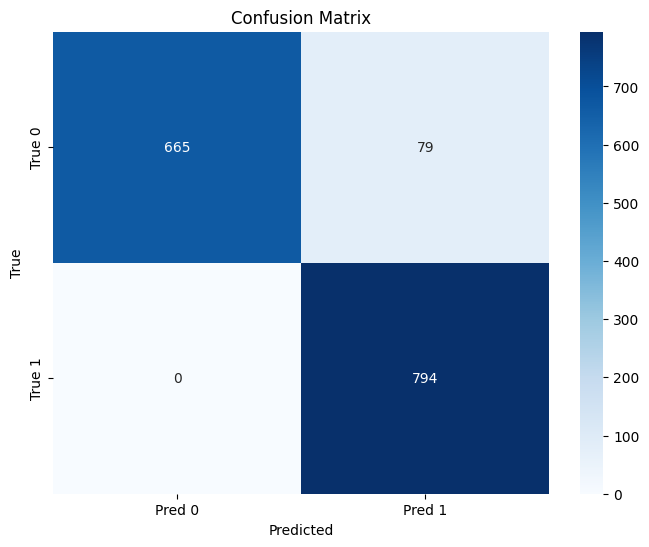

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
DF = df_C
cm = confusion_matrix(DF['encoded_label'], DF['prediction'])

print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [55]:
dss = {
    'postfix': dfs['postfix'],
    'mixed': dfs['mixed'],
    'infix': dfs['infix']
}

def gen_metrics(DF):

    precision = precision_score(DF['encoded_label'], DF['prediction'], average='weighted')
    recall = recall_score(DF['encoded_label'], DF['prediction'], average='weighted')
    f1 = f1_score(DF['encoded_label'], DF['prediction'], average='weighted')
    acc = accuracy_score(DF['encoded_label'], DF['prediction'])

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

for key in dss:
    print(key, f'len: {len(dss[key])}', gen_metrics(dss[key]))

postfix len: 1085 {'accuracy': 0.9447004608294931, 'f1': 0.9444647540302127, 'precision': 0.9493483898070668, 'recall': 0.9447004608294931}
mixed len: 5377 {'accuracy': 0.9596429235633253, 'f1': 0.9596265847298483, 'precision': 0.9625169240676994, 'recall': 0.9596429235633253}
infix len: 1538 {'accuracy': 0.9486345903771132, 'f1': 0.9484117258416594, 'precision': 0.9532827775022082, 'recall': 0.9486345903771132}


In [46]:
eval_steps = 100
filtered_logs = list(filter(lambda x: x['step'] % eval_steps == 0, log_history))

l1 = [x for x in filtered_logs if 'loss' in x]
l2  = [x for x in filtered_logs if 'loss' not in x]

c = map(lambda x,y:x|y,l1,l2)
df_logs = DataFrame(list(c))
df_logs

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_accuracy_label_bad,eval_accuracy_label_good,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.6770,10.117275,4.000000e-06,0.1,100,0.677610,0.562500,0.554351,0.568923,0.562500,0.427757,0.699622,15.1764,527.135,32.946
1,0.6494,16.417515,8.000000e-06,0.2,200,0.620407,0.643875,0.632382,0.666812,0.643875,0.467162,0.823707,15.5416,514.749,32.172
2,0.6148,10.697577,1.200000e-05,0.3,300,0.563627,0.688875,0.658923,0.797165,0.688875,0.393061,0.989912,15.7319,508.519,31.782
3,0.5385,14.890413,1.600000e-05,0.4,400,0.531589,0.717875,0.713480,0.733854,0.717875,0.593061,0.844893,16.2435,492.505,30.782
4,0.5516,31.666737,2.000000e-05,0.5,500,0.484817,0.762125,0.748657,0.837831,0.762125,0.530112,0.998235,16.9319,472.482,29.530
5,0.4716,34.229046,1.920000e-05,0.6,600,0.484203,0.779250,0.774309,0.808372,0.779250,0.629988,0.931148,16.2232,493.122,30.820
6,0.3855,7.888646,1.840000e-05,0.7,700,0.408473,0.825750,0.822049,0.857698,0.825750,0.679802,0.974275,16.5150,484.409,30.276
7,0.4175,15.546623,1.760000e-05,0.8,800,0.377431,0.821625,0.821306,0.824620,0.821625,0.776704,0.867339,16.5400,483.676,30.230
8,0.3726,19.766977,1.680000e-05,0.9,900,0.346883,0.848500,0.845282,0.882580,0.848500,0.702354,0.997226,16.4175,487.286,30.455
9,0.3878,5.159418,1.600000e-05,1.0,1000,0.405089,0.818625,0.817348,0.829096,0.818625,0.732838,0.905927,16.5285,484.013,30.251


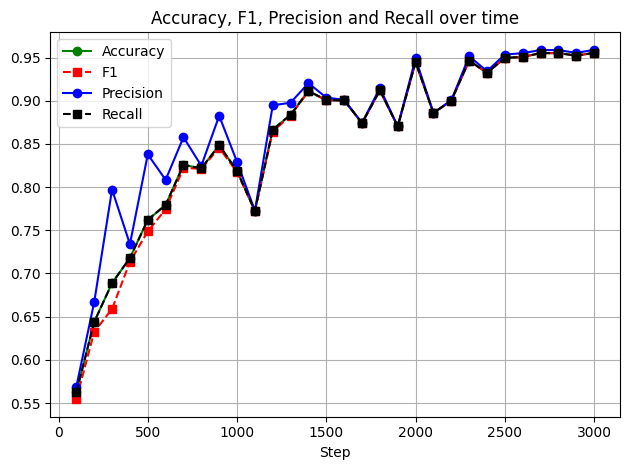

In [48]:
#@title metrics graph
plt.plot(df_logs['step'], df_logs['eval_accuracy'], marker='o', linestyle='-', color='g', label='Accuracy')

# Plot Humidity
plt.plot(df_logs['step'], df_logs['eval_f1'], marker='s', linestyle='--', color='r', label='F1')
plt.plot(df_logs['step'], df_logs['eval_precision'], marker='o', linestyle='-', color='b', label='Precision')

# Plot Humidity
plt.plot(df_logs['step'], df_logs['eval_recall'], marker='s', linestyle='--', color='black', label='Recall')

# Customize plot labels and title
plt.xlabel('Step')
# plt.ylabel('Step')
plt.title('Accuracy, F1, Precision and Recall over time')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

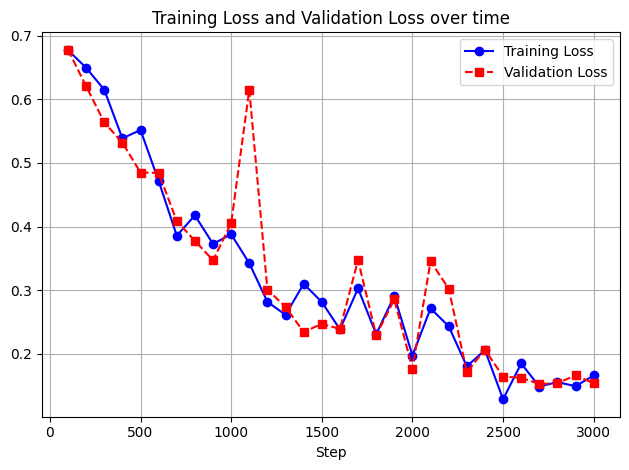

In [49]:
#@title loss graph

plt.plot(df_logs['step'], df_logs['loss'], marker='o', linestyle='-', color='b', label='Training Loss')

# Plot Humidity
plt.plot(df_logs['step'], df_logs['eval_loss'], marker='s', linestyle='--', color='r', label='Validation Loss')

# Customize plot labels and title
plt.xlabel('Step')
# plt.ylabel('Step')
plt.title('Training Loss and Validation Loss over time')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

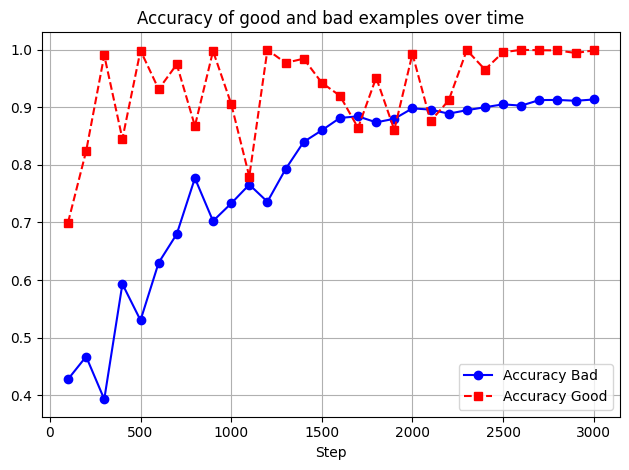

In [52]:
#@title good vs bad

plt.plot(df_logs['step'], df_logs['eval_accuracy_label_bad'], marker='o', linestyle='-', color='b', label='Accuracy Bad')

# Plot Humidity
plt.plot(df_logs['step'], df_logs['eval_accuracy_label_good'], marker='s', linestyle='--', color='r', label='Accuracy Good')

# Customize plot labels and title
plt.xlabel('Step')
# plt.ylabel('Step')
plt.title('Accuracy of good and bad examples over time')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
import re
def criteria(x):
    return x.split()

ds['split'] = ds['sentence'].apply(criteria)

ds

,sentence,label,split
0,( ( ( variable ) - [ variable ] - number + var...,good,"[(, (, (, variable, ), -, [, variable, ], -, n..."
1,[ number number - variable number + variable v...,good,"[[, number, number, -, variable, number, +, va..."
2,( [ variable number * ] - variable ) / ( numbe...,good,"[(, [, variable, number, *, ], -, variable, ),..."
3,number * [ variable ] + ( number / ( number ) ...,good,"[number, *, [, variable, ], +, (, number, /, (..."
4,( ( number ) ) + number + variable - variable,good,"[(, (, number, ), ), +, number, +, variable, -..."
...,...,...,...
19995,variable * [ variable number variable variable...,bad,"[variable, *, [, variable, number, variable, v..."
19996,[ variable number variable * * ] / [ ] number ...,bad,"[[, variable, number, variable, *, *, ], /, [,..."
19997,( [ number number / variable number - - number...,bad,"[(, [, number, number, /, variable, number, -,..."
19998,variable * [ variable variable variable + vari...,bad,"[variable, *, [, variable, variable, variable,..."


In [58]:
ds['token_number'] = ds['split'].apply(lambda x: len(x))
ds

,sentence,label,split,token_number
0,( ( ( variable ) - [ variable ] - number + var...,good,"[(, (, (, variable, ), -, [, variable, ], -, n...",15
1,[ number number - variable number + variable v...,good,"[[, number, number, -, variable, number, +, va...",27
2,( [ variable number * ] - variable ) / ( numbe...,good,"[(, [, variable, number, *, ], -, variable, ),...",19
3,number * [ variable ] + ( number / ( number ) ...,good,"[number, *, [, variable, ], +, (, number, /, (...",15
4,( ( number ) ) + number + variable - variable,good,"[(, (, number, ), ), +, number, +, variable, -...",11
...,...,...,...,...
19995,variable * [ variable number variable variable...,bad,"[variable, *, [, variable, number, variable, v...",32
19996,[ variable number variable * * ] / [ ] number ...,bad,"[[, variable, number, variable, *, *, ], /, [,...",24
19997,( [ number number / variable number - - number...,bad,"[(, [, number, number, /, variable, number, -,...",21
19998,variable * [ variable variable variable + vari...,bad,"[variable, *, [, variable, variable, variable,...",22


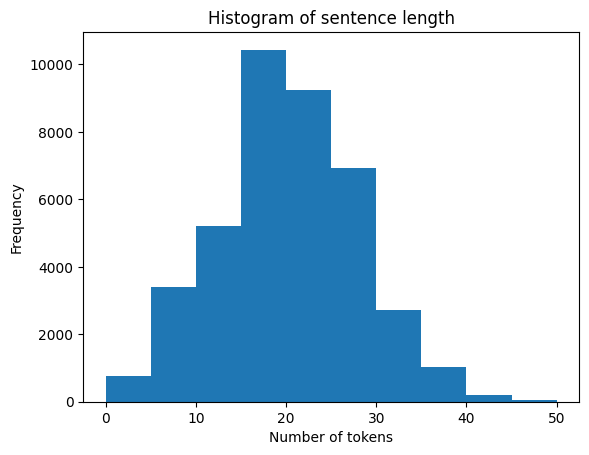

In [70]:
bins = [0,5,10,15,20,25,30,35,40,45,50]
plt.hist(ds['token_number'], bins=bins)
# plt.xtcks(bins)
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.title(f"Histogram of sentence length")
plt.show()